In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Trainig data

In [3]:
normalized_scan_100206 = np.load('normalised_data/normalized_scan_100206.npy')

In [4]:
normalized_scan_100206.shape

(935442, 288)

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [3]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [4]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [5]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [6]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [7]:
len(indices_beginning_0_all)

2234299

In [8]:
mask_0 = np.where(mask_100206_long[:,0] == 0)[0]

In [9]:
len(mask_0)

2722094

In [10]:
mask_100206_long_pro = np.copy(mask_100206_long)

In [11]:
mask_100206_long_pro[indices_beginning_0_all] = 0

In [12]:
mask_0_pro = np.where(mask_100206_long_pro[:,0] == 0)[0]
print(len(mask_0_pro))

2722908


In [13]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [14]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [17]:
big_b_indices = np.where(bvals_all != 0.005)[0]

In [18]:
bvals = bvals_all[big_b_indices]
print(bvals.shape)

(270,)


In [19]:
bvals

array([1.   , 1.995, 3.005, 0.995, 2.995, 2.005, 0.99 , 1.99 , 3.   ,
       1.   , 1.985, 2.995, 1.005, 1.995, 2.995, 0.995, 2.   , 3.01 ,
       3.005, 0.995, 2.005, 0.995, 1.99 , 2.985, 1.005, 2.   , 3.005,
       0.995, 1.995, 2.99 , 3.005, 0.995, 2.   , 0.99 , 1.99 , 2.99 ,
       0.995, 2.985, 1.995, 3.005, 0.995, 2.005, 1.   , 1.99 , 2.995,
       1.005, 2.005, 2.995, 3.   , 1.005, 1.985, 1.005, 2.985, 2.005,
       0.995, 1.99 , 3.005, 1.   , 2.99 , 2.   , 0.99 , 2.005, 2.995,
       1.   , 2.005, 3.   , 0.995, 2.005, 3.005, 1.005, 2.   , 3.01 ,
       0.99 , 2.005, 1.995, 1.   , 3.01 , 2.985, 1.005, 1.995, 3.   ,
       1.   , 2.005, 3.   , 0.99 , 2.005, 2.99 , 3.   , 1.   , 2.99 ,
       0.995, 1.995, 1.995, 1.005, 2.   , 2.995, 1.005, 2.01 , 2.995,
       1.005, 2.   , 3.01 , 1.   , 2.005, 2.99 , 0.99 , 2.985, 2.005,
       1.   , 2.005, 2.985, 0.995, 2.005, 2.99 , 0.995, 2.005, 2.99 ,
       1.005, 2.   , 3.005, 0.995, 2.995, 1.99 , 1.005, 0.995, 2.005,
       2.99 , 2.   ,

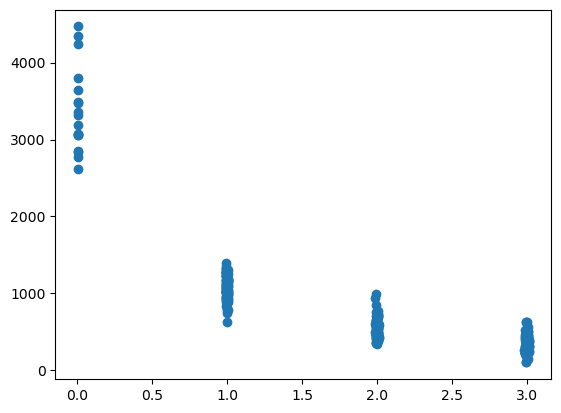

In [36]:
plt.plot(bvals, scan_100206_long_no_background[1400,:], "o")

In [20]:
scan_100206_long_no_background.shape

(935442, 288)

In [21]:
scan_100206_long_no_bg = np.copy(scan_100206_long_no_background)

In [22]:
scan_100206_long_no_bg = scan_100206_long_no_bg[:, big_b_indices]

In [23]:
scan_100206_long_no_bg.shape

(935442, 270)

In [28]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals)

In [29]:
S0_100206.shape

(935442, 1)

In [30]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [71]:
len(normalized_scan_100206)

935442

In [44]:
np.save('normalized_scan_100206.npy', normalized_scan_100206)

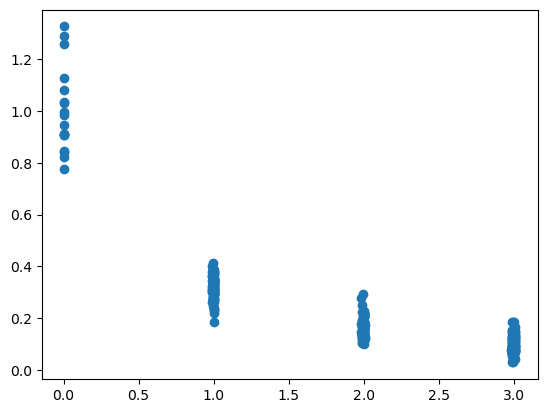

In [53]:
plt.plot(bvals, normalized_scan_100206[1400,:], "o")

## Neural Network

In [24]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [25]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [86]:
bvals_all = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
print(bvals_all.shape)

(288,)


In [87]:
bvals_all[big_b_indices].shape

(270,)

In [107]:
# def get_acquisition_scheme(bvals):
# #     bvals_all = np.loadtxt(
# #         config.data_folder2 + '/100206/bvals'
# #     ) * 1e-3
# #     # s/m^2
    
# #     bvals = bvals_all[big_b_indices]
#     gradient_directions = np.loadtxt(
#         config.data_folder2 + '/100206/bvecs'
#     ).T

#     delta = 0.0106
#     Delta = 0.0431
#     return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [26]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 6))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        s0 = params[:, 5].unsqueeze(1)
        X = s0*(volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso))
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1, s0

In [94]:
n = np.loadtxt(config.data_folder2 + '/100206/bvecs')
print(n.shape)
print(n[:,big_b_indices].T.shape)

(3, 288)
(270, 3)


In [27]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
print(b_values.shape)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

(270, 3)
torch.Size([270])


In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [29]:
batch_size = 128
num_batches = len(scan_100206_long_no_bg) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(scan_100206_long_no_bg.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [ ]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred, s0_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
            print("s0_pred:")
            print(s0_pred.shape)
            print(s0_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


  2%|█▍                                                         | 182/7308 [00:09<01:17, 92.50it/s]

In [31]:
net.load_state_dict(final_model)

<All keys matched successfully>

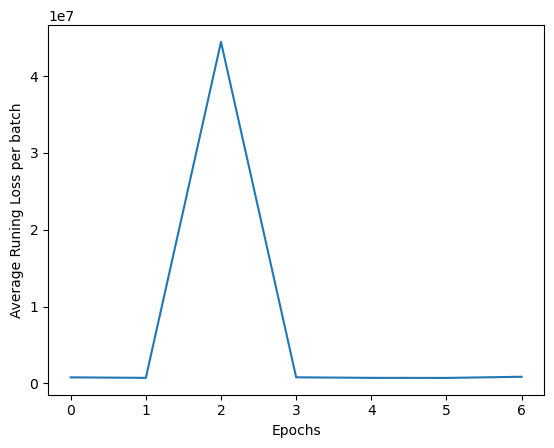

In [32]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [34]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=6, bias=True)
  )
)

In [16]:
torch.save(final_model, 'model_100206_not_converge.pt')

In [35]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train, s0_pred_train = net(torch.from_numpy(scan_100206_long_no_bg.astype(np.float32)))

In [36]:
X_pred_train.shape

torch.Size([935442, 270])

In [60]:
# Load model

# net_test = BallStickNet(gradient_directions, b_values)
# net_test.load_state_dict(torch.load('model_100206_61e.pt'))
# net_test.eval()
# X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test, s0_pred_test = net_test(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

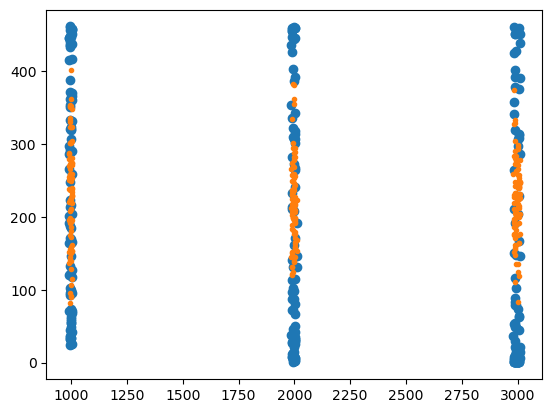

In [39]:
plt.plot(bvals*1e03, X_pred_train[200,:].detach().numpy(),  "o")
# plt.plot(X_pred_train[110,:].detach().numpy())
plt.plot(bvals*1e03,scan_100206_long_no_bg[200,:], ".")

In [70]:
b5_indices = np.where(bvals==0.005)

In [72]:
X_pred_train.detach().numpy()[2,b5_indices]

array([[363.97882, 363.975  , 363.9713 , 363.97144, 363.9675 , 363.9634 ,
        363.95895, 363.9608 , 363.95813, 363.96402, 363.9654 , 363.9675 ,
        363.95645, 363.95972, 363.96298, 363.96228, 363.96536, 363.96878]],
      dtype=float32)

In [65]:
X_pred_train[2,0]

tensor(363.9788, grad_fn=<SelectBackward0>)

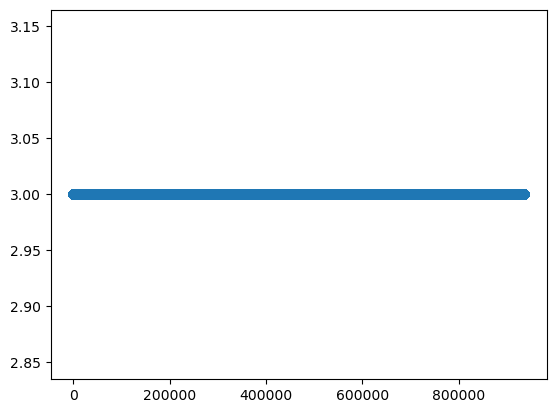

In [61]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

In [21]:
torch.min(lambda_par_pred_train)

tensor(0.1000, grad_fn=<MinBackward1>)

In [22]:
torch.max(lambda_par_pred_train)

tensor(3., grad_fn=<MaxBackward1>)

## Parameter maps

In [105]:
print(X_pred_train.shape)
print(normalized_scan_100206.shape)

torch.Size([935442, 288])
(935442, 288)


In [108]:
lambda_par_pred_train.shape

torch.Size([935442, 1])

In [127]:
mask_100206_long_pro.shape

(3658350, 1)

In [111]:
scan_100206_long.shape

(3658350, 288)

In [115]:
bg_indices = np.where(mask_100206_long_pro == 0)[0]

In [121]:
lambda_par_pred_train_cp = np.copy(lambda_par_pred_train.detach().numpy())

In [ ]:
def replace_ones(mask_100206, params):
    mask_100206_cp = np.copy(mask_100206)
    bg_indices = np.where(mask_100206_cp == 1)[0]
    for i, index in enumerate(bg_indices):
        mask_100206_cp[index] = params[i]
    return mask_100206_cp